In [1]:
# read, split, scale
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# read
df_wine = pd.read_csv('wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

# split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# scale
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Eigenvalues:
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.08414846  0.33051429  0.29595018  0.16831254  0.21432212
  0.2399553 ]


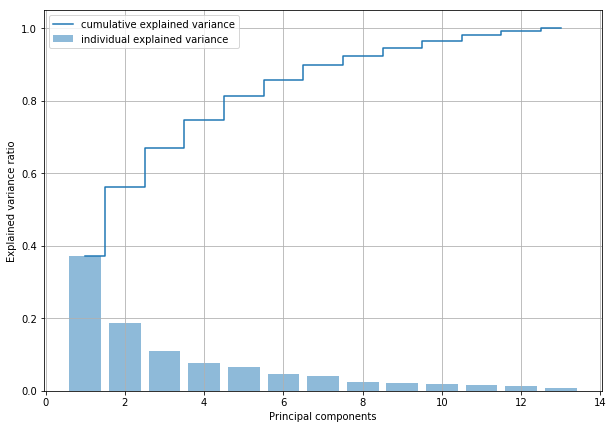

In [2]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('Eigenvalues:\n%s' % eigen_vals)
ev_total = sum(eigen_vals)
var_exp = [(i / ev_total) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 7))

plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.grid()
plt.show()

In [3]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse = True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n',w)
X_train_pca = X_train_std.dot(w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


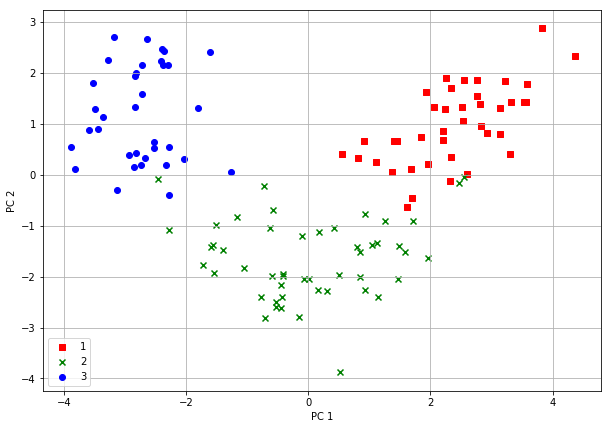

In [4]:
# plot the reduced set
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c = c, label = l, marker = m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.grid()
plt.show()

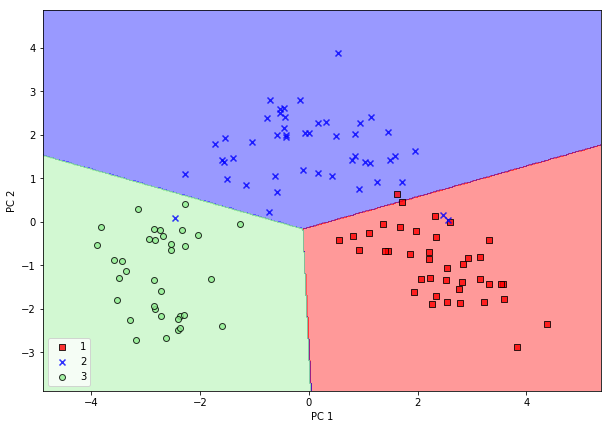

In [5]:
# sklearn PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from plot_decision_regions import plot_decision_regions

pca = PCA(n_components = 2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

# plot decision regions for training data
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

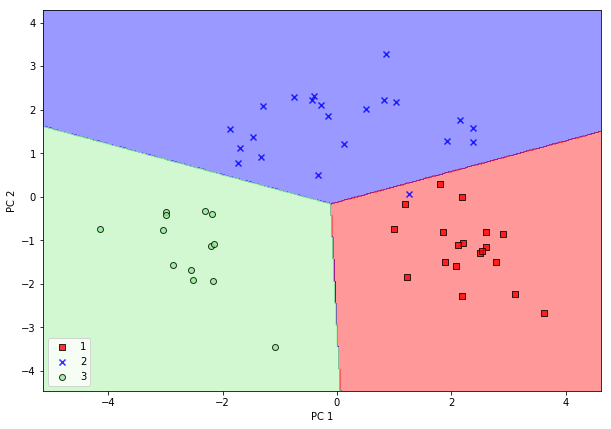

In [6]:
# plot decision regions for test data
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'lower left')
plt.show()

Eigenvalues in decreasing order:

643.015384346
225.086981854
1.52766688188e-13
1.49342242954e-13
5.45957902982e-14
5.45957902982e-14
3.50781709786e-14
2.24177095843e-14
1.3503315434e-14
1.3503315434e-14
1.24718701859e-14
1.24718701859e-14
6.59885434968e-15


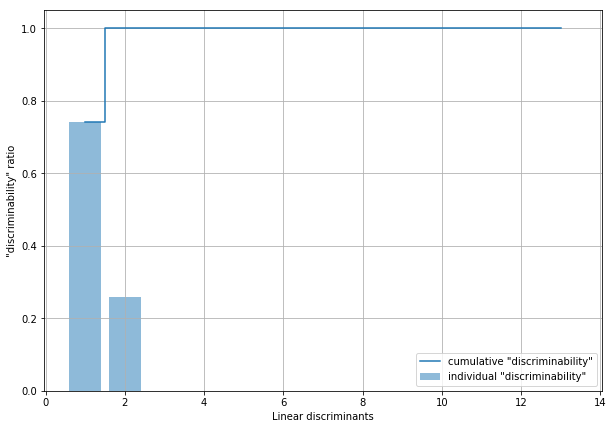

In [7]:
# LDA

# compute mean vectors
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis = 0))

# compute a scaled within-class scatter matrix
d = df_wine.shape[1] - 1
S_W = np.zeros((d, d))
for label in range(1, 4):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

# compute a between-class scatter matrix
mean_overall = np.mean(X_train_std, axis = 0)
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X[y == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

# compute eigenvalues
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse = True)
print('Eigenvalues in decreasing order:\n')
for ev in eigen_pairs:
    print(ev[0])

# plot linear discriminants
ev_total = sum(eigen_vals.real)
discr = [(i / ev_total) for i in sorted(eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1,14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.legend(loc='best')
plt.grid()
plt.show()

Matrix W:
 [[-0.0706686   0.37782797]
 [ 0.03594708  0.22229236]
 [-0.02630841  0.38130256]
 [ 0.18750118 -0.29552735]
 [-0.00326144 -0.01428977]
 [ 0.23275182 -0.01507122]
 [-0.7718927  -0.21487541]
 [-0.08025662 -0.07261057]
 [ 0.0895969  -0.17666664]
 [ 0.18147234  0.29094692]
 [-0.06309648 -0.2375536 ]
 [-0.37938634 -0.08668   ]
 [-0.33547942  0.58602274]]


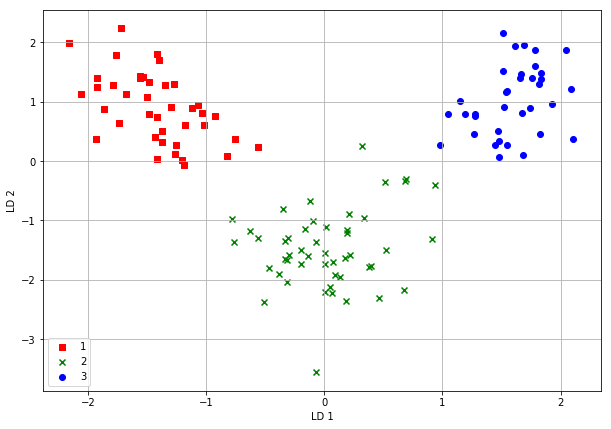

In [8]:
# create transformation matrix and transform training data
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n',w)
X_train_lda = X_train_std.dot(w)

# plot it
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1],
                c = c, label = l, marker = m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.grid()
plt.show()

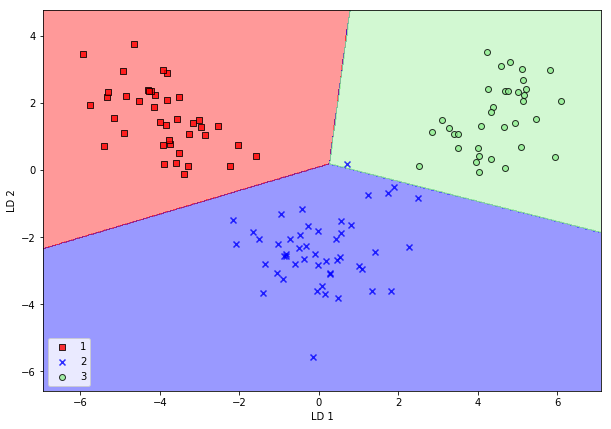

In [9]:
# sklearn LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)

X_train_lda = lda.fit_transform(X_train_std, y_train)

lr = LogisticRegression()
lr.fit(X_train_lda, y_train)

# plot decision regions for training data
plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()

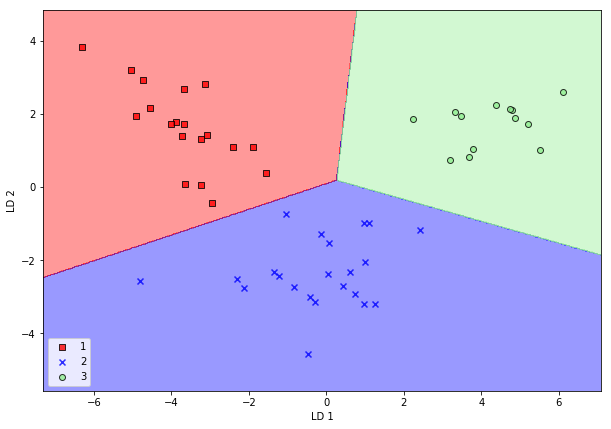

In [10]:
# run LDA on test data
X_test_lda = lda.transform(X_test_std)

# plot decision regions for training data
plot_decision_regions(X_test_lda, y_test, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.show()